In [1]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.6 MB/s eta 0:00:00


In [2]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.7/139.7 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 KB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 KB 10.8 MB/s eta 0:

In [3]:
!nvidia-smi

Fri Feb 24 10:39:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from tqdm import tqdm
import torch
import nltk
from nltk.corpus import stopwords

# Download the list of stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [6]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [7]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [8]:
dataset_sci = load_dataset("tomasg25/scientific_lay_summarisation","plos")

split_lengths = [len(dataset_sci[split])for split in dataset_sci]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_sci['train'].column_names}")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/24773 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Dataset scientific_lay_summarisation downloaded and prepared to /root/.cache/huggingface/datasets/tomasg25___scientific_lay_summarisation/plos/1.0.0/bf538a761aabe5d3389d3e4aa028b094528c5d7a6225147b843a63a3803e79f4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [24773, 1376, 1376]
Features: ['article', 'summary', 'section_headings', 'keywords', 'year', 'title']


In [ ]:
article=dataset_sci["test"][2]["article"]
print(article)
print(" ")
print("SUMMARY:")
print(dataset_sci["test"][2]["summary"])

Leishmaniasis , resulting from infection with the protozoan parasite Leishmania , consists of a wide spectrum of clinical manifestations , from healing cutaneous lesions to fatal visceral infections . A particularly severe form of cutaneous leishmaniasis , termed mucosal leishmaniasis , exhibits decreased IL-10 levels and an exaggerated inflammatory response that perpetuates the disease . Using a mouse model of leishmaniasis , we investigated what cytokines contribute to increased pathology when IL-10-mediated regulation is absent . Leishmania major infected C57BL/6 mice lacking IL-10 regulation developed larger lesions than controls , but fewer parasites . Both IFN-γ and IL-17 levels were substantially elevated in mice lacking the capacity to respond to IL-10 . IFN-γ promoted an increased infiltration of monocytes , while IL-17 contributed to an increase in neutrophils . Surprisingly , however , we found that IFN-γ did not contribute to increased pathology , but instead regulated the 

In [9]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
    cleaned=[]
    for row in column['article']:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        cleaned.append(row)
    return{
        "cleaned":cleaned
    }

In [10]:
dataset=dataset_sci.map(text_strip,batched=True)

Map:   0%|          | 0/24773 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

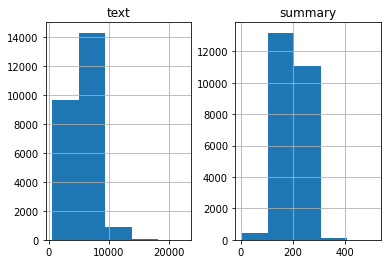

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in dataset['train']['cleaned']:
    text_count.append(len(sent.split()))
    
for sent in dataset['train']['summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [12]:
from datasets import DatasetDict
num_rows=len(dataset['train']['cleaned'])
new_dataset = dataset['train'].select(range(num_rows // 2))
new_dataset_dict = DatasetDict({'train': new_dataset, 'test': dataset['test'],'validation':dataset['validation']})
dataset=new_dataset_dict

In [13]:
dataset=dataset.remove_columns(['article', 'section_headings', 'keywords', 'year', 'title'])
dataset

DatasetDict({
    train: Dataset({
        features: ['summary', 'cleaned'],
        num_rows: 12386
    })
    test: Dataset({
        features: ['summary', 'cleaned'],
        num_rows: 1376
    })
    validation: Dataset({
        features: ['summary', 'cleaned'],
        num_rows: 1376
    })
})

In [14]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(data):
    removed=[]
    for row in data['cleaned']:
        words = row.split()

        # Remove the stopwords
        filtered_words = [word for word in words if word.casefold() not in stop_words]

        # Join the remaining words into a new sentence
        new_sentence = ' '.join(filtered_words)
        removed.append(new_sentence)

    return{
        "stopwords":removed
    }

In [15]:
dataset=dataset.map(remove_stopwords,batched=True)

Map:   0%|          | 0/12386 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

In [16]:
dataset=dataset.remove_columns(['cleaned'])

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_sci['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'article', column_summary='summary', batch_size=8)

100%|██████████| 172/172 [34:39<00:00, 12.09s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.017955,0.000227,0.017682,0.017677


In [17]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['stopwords'] , max_length = 1024, truncation = True,padding=True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True,padding=True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_tokenized = dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/12386 [00:00<?, ? examples/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

In [18]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['summary', 'stopwords', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12386
    })
    test: Dataset({
        features: ['summary', 'stopwords', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1376
    })
    validation: Dataset({
        features: ['summary', 'stopwords', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1376
    })
})

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
dataset_tokenized.save_to_disk("/content/drive/MyDrive/Datasets/summary")

Saving the dataset (0/1 shards):   0%|          | 0/12386 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1376 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1376 [00:00<?, ? examples/s]

In [21]:
from datasets import load_from_disk

dataset_tokenized = load_from_disk("/content/drive/MyDrive/Datasets/summary")

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [25]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [23]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-scientific_lay', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16,
    push_to_hub=True,save_strategy="epoch"
) 

In [26]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, 
                  train_dataset=dataset_tokenized["train"], 
                  eval_dataset=dataset_tokenized["validation"])

Cloning https://huggingface.co/Anandhulk/pegasus-scientific_lay into local empty directory.


In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: stopwords, summary. If stopwords, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12386
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 774
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` 

Step,Training Loss,Validation Loss
500,2.823400,2.595457


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: stopwords, summary. If stopwords, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1376
  Batch size = 1
Saving model checkpoint to pegasus-scientific_lay/checkpoint-774
Configuration saved in pegasus-scientific_lay/checkpoint-774/config.json
Configuration saved in pegasus-scientific_lay/checkpoint-774/generation_config.json
Model weights saved in pegasus-scientific_lay/checkpoint-774/pytorch_model.bin
tokenizer config file saved in pegasus-scientific_lay/checkpoint-774/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/checkpoint-774/special_tokens_map.json
tokenizer config file saved in pegasus-scientific_lay/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/special_tokens_map.json


Tra

TrainOutput(global_step=774, training_loss=3.120366418084433, metrics={'train_runtime': 9279.9694, 'train_samples_per_second': 1.335, 'train_steps_per_second': 0.083, 'total_flos': 3.578312730555187e+16, 'train_loss': 3.120366418084433, 'epoch': 1.0})

In [28]:
model_pegasus.save_pretrained("/content/drive/MyDrive/pegasus-samsum-model")

Configuration saved in /content/drive/MyDrive/pegasus-samsum-model/config.json
Configuration saved in /content/drive/MyDrive/pegasus-samsum-model/generation_config.json
Model weights saved in /content/drive/MyDrive/pegasus-samsum-model/pytorch_model.bin


In [30]:
tokenizer.save_pretrained("/content/drive/MyDrive/tokenizer")

tokenizer config file saved in /content/drive/MyDrive/tokenizer/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/tokenizer/special_tokens_map.json


('/content/drive/MyDrive/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/tokenizer/spiece.model',
 '/content/drive/MyDrive/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/tokenizer/tokenizer.json')

In [29]:
trainer.push_to_hub("pegasus-scientific_lay")

Saving model checkpoint to pegasus-scientific_lay
Configuration saved in pegasus-scientific_lay/config.json
Configuration saved in pegasus-scientific_lay/generation_config.json
Model weights saved in pegasus-scientific_lay/pytorch_model.bin
tokenizer config file saved in pegasus-scientific_lay/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file runs/Feb24_10-57-55_874f934bc4bc/events.out.tfevents.1677236327.874f934bc4bc.1344.0: 100%|########…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/Anandhulk/pegasus-scientific_lay
   89406b5..6dbc549  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Anandhulk/pegasus-scientific_lay
   89406b5..6dbc549  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'scientific_lay_summarisation', 'type': 'scientific_lay_summarisation', 'config': 'plos', 'split': 'validation', 'args': 'plos'}}
To https://huggingface.co/Anandhulk/pegasus-scientific_lay
   6dbc549..1cc3105  main -> main

   6dbc549..1cc3105  main -> main



'https://huggingface.co/Anandhulk/pegasus-scientific_lay/commit/6dbc54992512d86cd0708f97e2dadaf5128ea34e'

In [37]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model='pegasus-scientific_lay', tokenizer=tokenizer)

loading configuration file pegasus-scientific_lay/config.json
Model config PegasusConfig {
  "_name_or_path": "pegasus-scientific_lay",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "length_penalty": 0.8,
  "m

In [38]:
sample_text=""" this paragraph is about attention mechanism in  recurrent neural network.
Attention is simply a vector, often the outputs of dense layer using softmax function.Before Attention mechanism, translation relies on reading a complete sentence and compress all information into a fixed-length vector, as you can image, a sentence with hundreds of words represented by several words will surely lead to information loss, inadequate translation, etc.
However, attention partially fixes this problem. It allows machine translator to look over all the information the original sentence holds, then generate the proper word according to current word it works on and the context. It can even allow translator to zoom in or out focus on local or global features.
Attention is not mysterious or complex. It is just an interface formulated by parameters and delicate math. You could plug it anywhere you find it suitable, and potentially, the result may be enhanced.The core of Probabilistic Language Model is to assign a probability to a sentence by Markov Assumption. Due to the nature of sentences that consist of different numbers of words, RNN is naturally introduced to model the conditional probability among words.Vanilla RNN the classic one often gets trapped when modeling 
Structure Dilemma in real world, the length of outputs and inputs can be totally different, while Vanilla RNN can only handle fixed-length problem which is difficult for the alignment. Consider an EN-FR translation examples he doesn’t like apples Il n’aime pas les pommes.
Mathematical Nature it suffers from Gradient Vanishing/Exploding which means it is hard to train when sentences are long enough maybe at most 4 words.
"""

In [39]:
print(pipe(sample_text)[0]["summary_text"])

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Attention is a vector , often the outputs of dense layer using softmax function . It allows machine translator to look over all the information the original sentence holds , then generate the proper word according to current word . It can even allow translator to zoom in or out focus on local or global features . Attention is not mysterious or complex . It is just an interface formulated by parameters and delicate math .
